# Imports

In [385]:
import pandas as pd
import glob
import os
import numpy as np
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
from tqdm.auto import tqdm
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Functions

In [386]:
def check_missing_players(player_list, player_data):
    missing_players = []
    for game in player_list:
        for team in game:
            for player in team:
                if player.lower() not in player_data:
                    missing_players.append(player)
    return missing_players


def get_names(df, start, stop):
    player_list = []
    drop_list = df.iloc[:, start:stop:3].columns.tolist()
    name_df = df.drop(drop_list, axis=1, inplace=False)
    name_df = name_df.iloc[:, start:stop-len(drop_list)]
    for i in range(len(name_df)):
        players = name_df.iloc[i].tolist()
        players_sorted = [players[j] for j in range(0, len(players), 2)]
        players_sorted.sort(key=lambda x: players[players.index(x) + 1])
        player_list.append(players_sorted)
    return player_list


def list_stacker(pitchers, players):
    for i in range(len(pitchers)):
        players[i].insert(0, pitchers[i])
    return players


def get_game_data(paths, id_to_name):
    all_data = []
    for i in range(len(paths)):
        df = pd.read_csv(paths[i], header=0)
        visiting_players_ID = df[[col for col in df.columns if ('VisBat' in col or 'VisStPch' in col) and 'ID' in col]]
        home_players_ID = df[[col for col in df.columns if ('HmBat' in col or 'HmStPch' in col) and 'ID' in col]]
        print(visiting_players_ID)
        print(home_players_ID)
        # player_id_columns = ['VisStPchID', 'HmStPchID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID']
        visiting_id_columns = ['VisStPchID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']
        home_id_columns = ['HmStPchID','HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID']
        visiting_players=[]
        home_players=[]
        for column in visiting_id_columns:
            visiting_players[column] = visiting_players_ID[column].map(id_to_name)
        
        for column in home_id_columns:
            home_players[column] = home_players_ID[column].map(id_to_name)

        
        # home_pitchers = df.iloc[:, 104].tolist()
        # visiting_pitchers = df.iloc[:, 102].tolist()
        # visiting_players = list_stacker(visiting_pitchers, visiting_players)
        # home_players = list_stacker(home_pitchers, home_players)
        visiting_scores = df['VisRuns'].tolist()
        home_scores = df['HmRuns'].tolist()
        all_data.extend(list(zip(visiting_players, home_players, visiting_scores, home_scores)))
    return all_data


def get_player_data(paths):
    le = LabelEncoder()
    player_dfs = []
    for path in paths:
        df = pd.read_csv(path)
        df['Team'] = le.fit_transform(df['Team'])     
        if 'Pos' in df.columns:
            df['Pos'] = le.fit_transform(df['Pos'])
        if 'batting' in path:
            df['ExtraCol1'] = 0
            df['ExtraCol2'] = 0
            df['ExtraCol3'] = 0
            df['ExtraCol4'] = 0
            df['ExtraCol5'] = 0
            df['ExtraCol6'] = 0
            df['ExtraCol7'] = 0
            df['ExtraCol8'] = 0
        df.columns = ['Player'] + list(range(len(df.columns) - 1))
        df['Player'] = df['Player'].str.lower()
        player_dfs.append(df)
    combined_player = pd.concat(player_dfs)
    combined_player = combined_player.groupby('Player', as_index=False).mean()
    final_player = combined_player.set_index('Player').T.to_dict('list')
    return final_player


def get_example(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    stacked_vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    if game[2] > game[3]:
        label = 0 # might need to flip
    else:
        label = 1
    return stacked_vector, label


def generate_vectors_and_labels(game_data, player_data):
    vectors, labels = [], []
    for game in tqdm(game_data):
        try:
            vector, label = get_example(game, player_data)
            if np.isnan(vector).any() or np.isnan(label):
                continue
            vectors.append(vector)
            labels.append(label)
        except:
            continue
    return pd.DataFrame(np.array(vectors)), pd.DataFrame(np.array(labels))


def simulate_betting_season(bets, df, wallet_balance=1000.0):

    wallet_balance_history = [wallet_balance]  # Start with the initial wallet balance
    for bet in bets:
        bet_amount, bet_team, bet_date = bet
        row = df[(df['Date'] == bet_date) & ((df['HmTm'] == bet_team) | (df['VisTm'] == bet_team))]
        if not row.empty and not row.isnull().values.any():
            if row['winner'].values[0]==1:
                winner = row['HmTm'].values[0]
                if winner == bet_team:
                    if row['home_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['home_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['home_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            else:
                winner = row['VisTm'].values[0]
                if winner == bet_team:
                    if row['visiting_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['visiting_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['visiting_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            wallet_balance_history.append(wallet_balance)
        else:
            print(f"No betting data for date: {bet_date}")
    return wallet_balance, wallet_balance_history


def get_player_vector(players, player_data):
    return [player_data[player.lower()] for player in players]


def predict_game_outcome(player_list, player_data, model, augment=False, base_bet=100, scaler=1):
    results, bets, skipped = [], [], []
    for i in range(len(player_list)):
        try:
            visiting_players = player_list.iloc[i][0][0]
            home_players = player_list.iloc[i][0][1]
            visiting_vector = get_player_vector(visiting_players, player_data)
            home_vector = get_player_vector(home_players, player_data)
            game_vector = [item for sublist in visiting_vector + home_vector for item in sublist]  # Flatten the vectors
            game_vector = torch.tensor([game_vector], dtype=torch.float)
            model.eval()
            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results.append(pred)
            bets.append(base_bet * prob * scaler if augment else base_bet)
        except:
            skipped.append(i)
    return results, bets, skipped


def generate_bets(results, bets, df, skipped):
    final_bets = []
    for i, (result, (_, row)) in enumerate(zip(results, df.iterrows())):
        if i in skipped:
            continue
        if result == 1:
            bet_team = row['HmTm']
        else:
            bet_team = row['VisTm']
        bet_date = row['Date']
        final_bets.append((bets[i], bet_team, bet_date))
    return final_bets

In [387]:
# import pandas as pd
# import os
# import glob

# path = 'C:/Users/vile3/.cursor-tutor/projects/python/Lahman_compiled_player_data/'
# all_files = glob.glob(os.path.join(path, "*.csv"))
# people_path = 'C:/Users/vile3/.cursor-tutor/projects/python/Lahman_MLB_People/Lahman_MLB_People.csv'
# people_df = pd.read_csv(people_path)

# for file in all_files:
#     df = pd.read_csv(file)
#     df = df[df['yearID'] >= 2000]
#     df = pd.merge(df, people_df[['playerID', 'nameFirst', 'nameLast']], on='playerID', how='left')
#     df['Player'] = df['nameFirst'] + ' ' + df['nameLast']
#     df.drop(['playerID', 'nameFirst', 'nameLast', 'Unnamed: 0','stint','lgID' ], axis=1, inplace=True)  # Remove 'Unnamed' column
#     df.rename(columns={'teamID': 'Team'}, inplace=True)  # Rename 'teamID' to 'Team'
#     cols = df.columns.tolist()
#     cols = cols[-1:] + cols[:-1]  # Make 'Player' the first column
#     df = df[cols]
#     split_files = df.groupby('yearID')
#     df.drop(['yearID'], axis=1, inplace=True)
#     for name, group in split_files:
#         group.to_csv(f"{path}{os.path.splitext(os.path.basename(file))[0]}_{name}.csv", index=False)



# Data

In [388]:
def load_data(game_path, player_path, train_years, test_year):
        # Import all csv files
    all_game_csvs = [path.replace('\\', '/') for path in glob(game_path + '*.txt')]
    
    # Concatenate all dataframes
    all_data = pd.concat([pd.read_csv(f) for f in all_game_csvs])
    
    # Convert 'Date' column to datetime
    all_data['Date'] = pd.to_datetime(all_data['Date'], format='%Y%m%d')
    
    # Filter dataframes based on 'Date' column
    game_csvs_train = all_data[all_data['Date'].dt.year.isin(train_years)]
    game_csvs_test = all_data[all_data['Date'].dt.year == test_year]
    
    player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if str(test_year) not in path and any(str(year) in path for year in train_years)]
    player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if str(test_year) in path]
    print(game_csvs_train)
    print(player_csvs_train)
    print(game_csvs_test)
    print(player_csvs_test)

    people_df = pd.read_csv('./Lahman_MLB_People/Lahman_MLB_People.csv', header=0)
    people_df['Player'] = people_df['nameFirst'] + ' ' + people_df['nameLast']
    id_to_name = people_df.set_index('retroID')['Player'].to_dict()

    train_game_data = [game for game in get_game_data(game_csvs_train,id_to_name) if game[2] != game[3]]
    test_game_data = [game for game in get_game_data(game_csvs_test,id_to_name) if game[2] != game[3]]

    train_player_data = get_player_data(player_csvs_train)
    test_player_data = get_player_data(player_csvs_test)
   
    X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
    X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

    return X_train, y_train, X_test, y_test, train_game_data, test_game_data, train_player_data, test_player_data

# load data
game_path = './Lahman_MLB_per_game_data/'
player_path = './Lahman_compiled_player_data/'

test_year = 2021
train_years = range(2010, test_year) #train years from 2010 to test year -1 for some reason range reduces the year by 1.

X_train, y_train, X_test, y_test, train_game_data, test_game_data, train_player_data, test_player_data = load_data(game_path, player_path, train_years, test_year)


player_paths = [path.replace('\\', '/') for path in glob(player_path + '*.csv')]
for path in player_paths:
    df = pd.read_csv(path)
    view_data(df)

xlsx_path = './betting_odds/'
# glfields_path = './alldata/gamelogs/glfields.txt'
betting_paths = [path for path in glob(xlsx_path + '*.xlsx')]
# schedule_paths = [f'./alldata/schedules/{year}schedule.csv' for year in range(2010, 2024)]



[]
[]
[]
[]


ValueError: No objects to concatenate

In [ ]:
xlsx_dataframes = []
for i, path in enumerate(betting_paths):
    temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
    temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
    year = path[-9:-5]  # extract year from file name
    if 'Date' in temp_df.columns:
        temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
    xlsx_dataframes.append(temp_df)


date1, date2 = int(str(test_year)+'0101'), int(str(test_year+1)+'0101') 
for i in range(len(xlsx_dataframes)):
    xlsx_dataframes[i] = xlsx_dataframes[i][(xlsx_dataframes[i]['Date'].astype(int) >= date1) & (xlsx_dataframes[i]['Date'].astype(int) <= date2)]

try:
    xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
except pd.errors.InvalidIndexError:
    print('Error: Reindexing only valid with uniquely valued Index objects')

# with open(glfields_path, 'r') as file:
#     glfields_data = file.read()

xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

home_teams_df.rename(columns={'Team': 'HmTm', 'Open': 'home_open'}, inplace=True)
visiting_teams_df.rename(columns={'Team': 'VisTm', 'Open': 'visiting_open'}, inplace=True)

# Merge on 'date'
xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
xlsx_dataframes = xlsx_dataframes[['Date', 'HmTm', 'VisTm','home_open','visiting_open']]
print(xlsx_dataframes)
# Define the new path

path_csv = './Lahman_MLB_per_game_data/Lahman_MLB_per_game_data.csv'




# Read the CSV file

df = pd.read_csv(path_csv, header=0)
df = df[(df['Date'] >= date1) & (df['Date'] <= date2)]
print(df)
# Replace the txt_dataframes with the new dataframe
txt_dataframes = [df]

# The rest of your code remains the same
txt_dataframes_concat = pd.concat(txt_dataframes)

# Determine the winning team for each game and add it as a new column 'winner'
txt_dataframes_concat['winner'] = txt_dataframes_concat.apply(lambda row: 1 if row["HmRuns"] > row["VisRuns"] else 2 if row["HmRuns"] == row["VisRuns"] else 0, axis=1)

# # Adjust the column names to match the new CSV file
# txt_dataframes_concat = txt_dataframes_concat[['Date', 'HmTm', 'VisTm', 'HmStPchNm', 'VisStPchNm', 
#                                               'HmBat1Nm', 'HmBat2Nm', 'HmBat3Nm', 
#                                               'HmBat4Nm', 'HmBat5Nm', 'HmBat6Nm', 
#                                               'HmBat7Nm', 'HmBat8Nm', 'HmBat9Nm', 
#                                               'VisBat1Nm', 'VisBat2Nm', 'VisBat3Nm', 
#                                               'VisBat4Nm', 'VisBat5Nm', 'VisBat6Nm', 
#                                               'VisBat7Nm', 'VisBat8Nm', 'VisBat9Nm',
#                                               'winner']]

# Adjust the column names to match the new CSV file
txt_dataframes_concat = txt_dataframes_concat[['Date', 'HmTm', 'VisTm', 'HmStPchID', 'VisStPchID', 
                                              'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 
                                              'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 
                                              'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 
                                              'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 
                                              'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 
                                              'VisBat7ID', 'VisBat8ID', 'VisBat9ID',
                                              'winner']]


xlsx_dataframes['Date'] = xlsx_dataframes['Date'].astype(int)
# Now perform the merge operation

merged_dataframes=[]
merged_dataframes = pd.merge(xlsx_dataframes, txt_dataframes_concat, on=['Date', 'HmTm', 'VisTm'])
merged_dataframes_full = pd.merge(txt_dataframes_concat, xlsx_dataframes, on=['Date', 'HmTm', 'VisTm'], how="left")

player_list_concat=[]
player_list_concat = pd.concat(txt_dataframes)




# player_list_concat = player_list_concat[['Date', 'HmTm', 'VisTm', 'HmStPchNm', 'VisStPchNm', 
#                                           'HmBat1Nm', 'HmBat2Nm', 'HmBat3Nm', 
#                                           'HmBat4Nm', 'HmBat5Nm', 'HmBat6Nm', 
#                                           'HmBat7Nm', 'HmBat8Nm', 'HmBat9Nm', 
#                                           'VisBat1Nm', 'VisBat2Nm', 'VisBat3Nm', 
#                                           'VisBat4Nm', 'VisBat5Nm', 'VisBat6Nm', 
#                                           'VisBat7Nm', 'VisBat8Nm', 'VisBat9Nm',
#                                           'HmRuns', 'VisRuns',
#                                           'HmBat1Pos', 'HmBat2Pos', 
#                                           'HmBat3Pos', 'HmBat4Pos', 
#                                           'HmBat5Pos', 'HmBat6Pos', 
#                                           'HmBat7Pos', 'HmBat8Pos', 
#                                           'HmBat9Pos', 'VisBat1Pos', 
#                                           'VisBat2Pos', 'VisBat3Pos', 
#                                           'VisBat4Pos', 'VisBat5Pos', 
#                                           'VisBat6Pos', 'VisBat7Pos', 
#                                           'VisBat8Pos', 'VisBat9Pos']]

player_list_concat = player_list_concat[['Date', 'HmTm', 'VisTm', 'HmStPchID', 'VisStPchID', 
                                          'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 
                                          'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 
                                          'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 
                                          'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 
                                          'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 
                                          'VisBat7ID', 'VisBat8ID', 'VisBat9ID',
                                          'HmRuns', 'VisRuns',
                                          'HmBat1Pos', 'HmBat2Pos', 
                                          'HmBat3Pos', 'HmBat4Pos', 
                                          'HmBat5Pos', 'HmBat6Pos', 
                                          'HmBat7Pos', 'HmBat8Pos', 
                                          'HmBat9Pos', 'VisBat1Pos', 
                                          'VisBat2Pos', 'VisBat3Pos', 
                                          'VisBat4Pos', 'VisBat5Pos', 
                                          'VisBat6Pos', 'VisBat7Pos', 
                                          'VisBat8Pos', 'VisBat9Pos']]

# Replace player IDs with names in merged_player_dataframe

print(player_list_concat)
# Replace player IDs with names in player_list_concat
player_id_columns = ['VisStPchID', 'HmStPchID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID']
for column in player_id_columns:
    player_list_concat[column] = player_list_concat[column].map(id_to_name)

# Get unique player IDs from the DataFrame
unique_player_ids = pd.unique(player_list_concat[player_id_columns].values.ravel('K'))

# Find missing player IDs
missing_player_ids = [player_id for player_id in unique_player_ids if player_id not in id_to_name]

# Print missing player IDs
print(f"Missing player IDs: {missing_player_ids}")

# If you want to get the rows in the DataFrame that contain missing player IDs
missing_player_rows = player_list_concat[player_list_concat[player_id_columns].isin(missing_player_ids).any(axis=1)]

# Print rows with missing player IDs
print("Rows with missing player IDs:")
print(missing_player_rows)

player_list_concat.rename(columns={'VisStPchID': 'VisStPchNm', 'HmStPchID': 'HmStPchNm', 
                                   'VisBat1ID': 'VisBat1Nm', 'VisBat2ID': 'VisBat2Nm', 
                                   'VisBat3ID': 'VisBat3Nm', 'VisBat4ID': 'VisBat4Nm', 
                                   'VisBat5ID': 'VisBat5Nm', 'VisBat6ID': 'VisBat6Nm', 
                                   'VisBat7ID': 'VisBat7Nm', 'VisBat8ID': 'VisBat8Nm', 
                                   'VisBat9ID': 'VisBat9Nm', 'HmBat1ID': 'HmBat1Nm', 
                                   'HmBat2ID': 'HmBat2Nm', 'HmBat3ID': 'HmBat3Nm', 
                                   'HmBat4ID': 'HmBat4Nm', 'HmBat5ID': 'HmBat5Nm', 
                                   'HmBat6ID': 'HmBat6Nm', 'HmBat7ID': 'HmBat7Nm', 
                                   'HmBat8ID': 'HmBat8Nm', 'HmBat9ID': 'HmBat9Nm'}, inplace=True)

player_list_concat['lineup'] = player_list_concat.apply(lambda row: [
    (
        (row['VisStPchNm'],) +
        tuple(row[f'VisBat{i}Nm'] for i in sorted(range(1, 10), key=lambda i: row[f'VisBat{i}Pos']))
    ),
    (
        (row['HmStPchNm'],) +
        tuple(row[f'HmBat{i}Nm'] for i in sorted(range(1, 10), key=lambda i: row[f'HmBat{i}Pos']))
    ),
], axis=1).tolist()

merged_player_dataframe = pd.merge(xlsx_dataframes, player_list_concat, on=['Date', 'HmTm', 'VisTm'])
print(merged_player_dataframe)
# player_id_columns = ['VisStPchID', 'HmStPchID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID']
# for column in player_id_columns:
#     merged_player_dataframe[column] = merged_player_dataframe[column].map(id_to_name)

# merged_player_dataframe.rename(columns={'VisStPchID': 'VisStPchNm', 'HmStPchID': 'HmStPchNm', 
#                                    'VisBat1ID': 'VisBat1Nm', 'VisBat2ID': 'VisBat2Nm', 
#                                    'VisBat3ID': 'VisBat3Nm', 'VisBat4ID': 'VisBat4Nm', 
#                                    'VisBat5ID': 'VisBat5Nm', 'VisBat6ID': 'VisBat6Nm', 
#                                    'VisBat7ID': 'VisBat7Nm', 'VisBat8ID': 'VisBat8Nm', 
#                                    'VisBat9ID': 'VisBat9Nm', 'HmBat1ID': 'HmBat1Nm', 
#                                    'HmBat2ID': 'HmBat2Nm', 'HmBat3ID': 'HmBat3Nm', 
#                                    'HmBat4ID': 'HmBat4Nm', 'HmBat5ID': 'HmBat5Nm', 
#                                    'HmBat6ID': 'HmBat6Nm', 'HmBat7ID': 'HmBat7Nm', 
#                                    'HmBat8ID': 'HmBat8Nm', 'HmBat9ID': 'HmBat9Nm'}, inplace=True)

          Date HmTm VisTm home_open visiting_open
0     20210401  CUB   PIT      -205           183
1     20210401  PHI   ATL      -105          -105
2     20210401  SDG   ARI      -210           188
3     20210401  COL   LAD       188          -210
4     20210401  CIN   STL      -115           105
...        ...  ...   ...       ...           ...
2457  20211027  HOU   ATL      -115          -105
2458  20211029  ATL   HOU      -115          -105
2459  20211030  ATL   HOU      -115          -105
2460  20211031  ATL   HOU      -105          -115
2461  20211102  HOU   ATL      -120           100

[2462 rows x 5 columns]
       Unnamed: 0      Date  DblHdr  Day VisTm VisTmLg  VisTmGNum HmTm HmTmLg  \
49486       49487  20210401       0  Thu   PIT      NL          1  CHN     NL   
49487       49488  20210401       0  Thu   SLN      NL          1  CIN     NL   
49488       49489  20210401       0  Thu   LAN      NL          1  COL     NL   
49489       49490  20210401       0  Thu   TBA     

In [ ]:
xlsx_dataframes = []
for i, path in enumerate(paths):
    temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
    temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
    year = path[-9:-5]  # extract year from file name
    if 'Date' in temp_df.columns:
        temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
    xlsx_dataframes.append(temp_df)

try:
    xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
except pd.errors.InvalidIndexError:
    print('Error: Reindexing only valid with uniquely valued Index objects')

with open(glfields_path, 'r') as file:
    glfields_data = file.read()

xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

home_teams_df.rename(columns={'Date': 'date', 'Team': 'home_team', 'Open': 'home_open'}, inplace=True)
visiting_teams_df.rename(columns={'Date': 'date', 'Team': 'visiting_team', 'Open': 'visiting_open'}, inplace=True)

# Merge on 'date'
xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]
print(xlsx_dataframes)
headers = [
    "date",
    "number_of_game",
    "day_of_week",
    "visiting_team",
    "visiting_team_league",
    "visiting_team_game_number",
    "home_team",
    "home_team_league",
    "home_team_game_number",
    "visiting_team_score",
    "home_team_score",
    "length_of_game_in_outs",
    "day_night_indicator",
    "completion_information",
    "forfeit_information",
    "protest_information",
    "park_id",
    "attendance",
    "time_of_game_in_minutes",
    "visiting_team_line_scores",
    "home_team_line_scores",
    "visiting_team_at_bats",
    "visiting_team_hits",
    "visiting_team_doubles",
    "visiting_team_triples",
    "visiting_team_homeruns",
    "visiting_team_RBI",
    "visiting_team_sacrifice_hits",
    "visiting_team_sacrifice_flies",
    "visiting_team_hit_by_pitch",
    "visiting_team_walks",
    "visiting_team_intentional_walks",
    "visiting_team_strikeouts",
    "visiting_team_stolen_bases",
    "visiting_team_caught_stealing",
    "visiting_team_grounded_into_double_plays",
    "visiting_team_awarded_first_on_catchers_interference",
    "visiting_team_left_on_base",
    "visiting_team_pitchers_used",
    "visiting_team_individual_earned_runs",
    "visiting_team_team_earned_runs",
    "visiting_team_wild_pitches",
    "visiting_team_balks",
    "visiting_team_putouts",
    "visiting_team_assists",
    "visiting_team_errors",
    "visiting_team_passed_balls",
    "visiting_team_double_plays",
    "visiting_team_triple_plays",
    "home_team_at_bats",
    "home_team_hits",
    "home_team_doubles",
    "home_team_triples",
    "home_team_homeruns",
    "home_team_RBI",
    "home_team_sacrifice_hits",
    "home_team_sacrifice_flies",
    "home_team_hit_by_pitch",
    "home_team_walks",
    "home_team_intentional_walks",
    "home_team_strikeouts",
    "home_team_stolen_bases",
    "home_team_caught_stealing",
    "home_team_grounded_into_double_plays",
    "home_team_awarded_first_on_catchers_interference",
    "home_team_left_on_base",
    "home_team_pitchers_used",
    "home_team_individual_earned_runs",
    "home_team_team_earned_runs",
    "home_team_wild_pitches",
    "home_team_balks",
    "home_team_putouts",
    "home_team_assists",
    "home_team_errors",
    "home_team_passed_balls",
    "home_team_double_plays",
    "home_team_triple_plays",
    "home_plate_umpire_id",
    "home_plate_umpire_name",
    "first_base_umpire_id",
    "first_base_umpire_name",
    "second_base_umpire_id",
    "second_base_umpire_name",
    "third_base_umpire_id",
    "third_base_umpire_name",
    "left_field_umpire_id",
    "left_field_umpire_name",
    "right_field_umpire_id",
    "right_field_umpire_name",
    "visiting_team_manager_id",
    "visiting_team_manager_name",
    "home_team_manager_id",
    "home_team_manager_name",
    "winning_pitcher_id",
    "winning_pitcher_name",
    "losing_pitcher_id",
    "losing_pitcher_name",
    "saving_pitcher_id",
    "saving_pitcher_name",
    "game_winning_rbi_batter_id",
    "game_winning_rbi_batter_name",
    "visiting_starting_pitcher_id",
    "visiting_starting_pitcher_name",
    "home_starting_pitcher_id",
    "home_starting_pitcher_name",
]
for i in range(1, 10):
    headers.extend([
        f"visiting_starting_player_{i}_id",
        f"visiting_starting_player_{i}_name",
        f"visiting_starting_player_{i}_defensive_position"
    ])

for i in range(1, 10):
    headers.extend([
        f"home_starting_player_{i}_id",
        f"home_starting_player_{i}_name",
        f"home_starting_player_{i}_defensive_position"
    ])

headers.extend(["additional_information", "acquisition_information"])

txt_dataframes = []
for path_txt in paths_txt:
    df = pd.read_csv(path_txt, delimiter = ",", quotechar='"', quoting=1, header = None)
    df.columns = headers
    txt_dataframes.append(df)
    # view_data(df)
# txt_dataframes = txt_dataframes.replace({',': '', '\"': ''}, regex=True)
# If you want to view the file in Excel, uncomment the following line
# os.startfile(xlsx_files[0])
# Concatenate all dataframes in txt_dataframes into a single dataframe
txt_dataframes_concat = pd.concat(txt_dataframes)

# Determine the winning team for each game and add it as a new column 'winner'
txt_dataframes_concat['winner'] = txt_dataframes_concat.apply(lambda row: 1 if row["home_team_score"] > row["visiting_team_score"] else 2 if row["home_team_score"] == row["visiting_team_score"] else 0, axis=1)

# Drop all columns except for the visiting and home pitchers, starting players, home_team, visiting_team, date, coach, and winner
# txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
#                                               'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
#                                               'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
#                                               'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
#                                               'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
#                                               'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
#                                               'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
#                                               'home_team_score','visiting_team_score','winner']]
txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'winner']]

xlsx_dataframes['date'] = xlsx_dataframes['date'].astype(int)
txt_dataframes_concat['date'] = txt_dataframes_concat['date']
# Now perform the merge operation
merged_dataframes = pd.merge(xlsx_dataframes, txt_dataframes_concat, on=['date', 'home_team', 'visiting_team'])
merged_dataframes_full = pd.merge(txt_dataframes_concat,xlsx_dataframes, on=['date', 'home_team', 'visiting_team'],how="left")

# Now, merged_data should only contain bets on actual games played

player_list_concat = pd.concat(txt_dataframes)
player_list_concat = player_list_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'home_team_score','visiting_team_score',
                                              'home_starting_player_1_defensive_position', 'home_starting_player_2_defensive_position', 
                                              'home_starting_player_3_defensive_position', 'home_starting_player_4_defensive_position', 
                                              'home_starting_player_5_defensive_position', 'home_starting_player_6_defensive_position', 
                                              'home_starting_player_7_defensive_position', 'home_starting_player_8_defensive_position', 
                                              'home_starting_player_9_defensive_position', 'visiting_starting_player_1_defensive_position', 
                                              'visiting_starting_player_2_defensive_position', 'visiting_starting_player_3_defensive_position', 
                                              'visiting_starting_player_4_defensive_position', 'visiting_starting_player_5_defensive_position', 
                                              'visiting_starting_player_6_defensive_position', 'visiting_starting_player_7_defensive_position', 
                                              'visiting_starting_player_8_defensive_position', 'visiting_starting_player_9_defensive_position']]

player_list_concat['lineup'] = player_list_concat.apply(lambda row: [
    (
        (row['visiting_starting_pitcher_name'],) +
        tuple(row[f'visiting_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'visiting_starting_player_{i}_defensive_position']))
    ),
    (
        (row['home_starting_pitcher_name'],) +
        tuple(row[f'home_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'home_starting_player_{i}_defensive_position']))
    ),
    # row['visiting_team_score'],
    # row['home_team_score']
], axis=1).tolist()

merged_player_dataframe = pd.merge(xlsx_dataframes, player_list_concat, on=['date', 'home_team', 'visiting_team'])

KeyboardInterrupt: 

In [ ]:
print(merged_player_dataframe)

         Date HmTm VisTm home_open visiting_open         HmStPchNm  \
0    20210401  PHI   ATL      -105          -105        Aaron Nola   
1    20210401  DET   CLE       170          -190         Matt Boyd   
2    20210401  OAK   HOU      -105          -105     Chris Bassitt   
3    20210401  MIL   MIN      -105          -105  Brandon Woodruff   
4    20210402  OAK   HOU      -135           115     Jesus Luzardo   
..        ...  ...   ...       ...           ...               ...   
962  20211003  ARI   COL       105          -125    Humberto Mejia   
963  20211003  TEX   CLE      -115          -105      Dane Dunning   
964  20211003  TOR   BAL      -360           290      Hyun Jin Ryu   
965  20211003  HOU   OAK      -195           165      Jose Urquidy   
966  20211003  WAS   BOS       180          -220         Joan Adon   

           VisStPchNm          HmBat1Nm            HmBat2Nm  \
0           Max Fried  Andrew McCutchen        Rhys Hoskins   
1        Shane Bieber   Robbie Gr

In [ ]:
na_rows = player_list_concat[player_list_concat.isna().any(axis=1)]
print(na_rows)

Empty DataFrame
Columns: [Date, HmTm, VisTm, HmStPchNm, VisStPchNm, HmBat1Nm, HmBat2Nm, HmBat3Nm, HmBat4Nm, HmBat5Nm, HmBat6Nm, HmBat7Nm, HmBat8Nm, HmBat9Nm, VisBat1Nm, VisBat2Nm, VisBat3Nm, VisBat4Nm, VisBat5Nm, VisBat6Nm, VisBat7Nm, VisBat8Nm, VisBat9Nm, HmRuns, VisRuns, HmBat1Pos, HmBat2Pos, HmBat3Pos, HmBat4Pos, HmBat5Pos, HmBat6Pos, HmBat7Pos, HmBat8Pos, HmBat9Pos, VisBat1Pos, VisBat2Pos, VisBat3Pos, VisBat4Pos, VisBat5Pos, VisBat6Pos, VisBat7Pos, VisBat8Pos, VisBat9Pos, lineup]
Index: []

[0 rows x 44 columns]


In [ ]:


# # load data
# game_path = './game_data/'
# player_path = './player_data/'

# game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2019' not in path and '2020' not in path and '2021' not in path and '2022' not in path and '2023' not in path]
# game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2019' in path]

# player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2019' not in path and '2020' not in path and '2021' not in path and '2022' not in path and '2023' not in path]
# player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2019' in path]

# train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
# test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

# train_player_data = get_player_data(player_csvs_train)
# test_player_data = get_player_data(player_csvs_test)

# X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
# X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

In [ ]:
print(merged_player_dataframe)

         Date HmTm VisTm home_open visiting_open         HmStPchNm  \
0    20210401  PHI   ATL      -105          -105        Aaron Nola   
1    20210401  DET   CLE       170          -190         Matt Boyd   
2    20210401  OAK   HOU      -105          -105     Chris Bassitt   
3    20210401  MIL   MIN      -105          -105  Brandon Woodruff   
4    20210402  OAK   HOU      -135           115     Jesus Luzardo   
..        ...  ...   ...       ...           ...               ...   
962  20211003  ARI   COL       105          -125    Humberto Mejia   
963  20211003  TEX   CLE      -115          -105      Dane Dunning   
964  20211003  TOR   BAL      -360           290      Hyun Jin Ryu   
965  20211003  HOU   OAK      -195           165      Jose Urquidy   
966  20211003  WAS   BOS       180          -220         Joan Adon   

           VisStPchNm          HmBat1Nm            HmBat2Nm  \
0           Max Fried  Andrew McCutchen        Rhys Hoskins   
1        Shane Bieber   Robbie Gr

In [ ]:
# xlsx_dataframes.to_csv('output.csv', index=False)

In [ ]:
# print(merged_player_dataframe['lineup'])

# NN

In [ ]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)
model

neural_net(
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.15, inplace=False)
  (input_layer): Linear(in_features=520, out_features=1040, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=1040, out_features=1040, bias=True)
  )
  (output_layer): Linear(in_features=1040, out_features=2, bias=True)
)

In [ ]:
train_dataset = vector_dataset(X_train, y_train)
test_dataset = vector_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [ ]:
patience = 15
best_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'  # File path for saving the best model

for epoch in range(50):  # number of epochs
    model.train()
    train_losses = []
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    print(f'Training Loss: {avg_train_loss}')

    model.eval()
    valid_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            valid_losses.append(loss.item())

    avg_valid_loss = np.mean(valid_losses)
    print(f'Validation Loss: {avg_valid_loss}')

    # Save the model at each epoch
    epoch_model_path = f'model_epoch_{epoch + 1}.pth'
    torch.save(model.state_dict(), epoch_model_path)

    # Update the best model if validation loss improves
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Evaluate the best model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Epoch 1: 100%|██████████| 224/224 [00:04<00:00, 47.60it/s]


Training Loss: 1.0421937637563263
Validation Loss: 0.6795613139867782


Epoch 2: 100%|██████████| 224/224 [00:04<00:00, 46.65it/s]


Training Loss: 0.6907762467328992
Validation Loss: 0.6925537258386611


Epoch 3: 100%|██████████| 224/224 [00:04<00:00, 46.47it/s]


Training Loss: 0.6863657252064773
Validation Loss: 0.6834633946418762


Epoch 4: 100%|██████████| 224/224 [00:04<00:00, 48.10it/s]


Training Loss: 0.6841867951942342
Validation Loss: 0.6818893820047378


Epoch 5: 100%|██████████| 224/224 [00:04<00:00, 48.49it/s]


Training Loss: 0.6815059602792773
Validation Loss: 0.6828239232301712


Epoch 6: 100%|██████████| 224/224 [00:04<00:00, 47.65it/s]


Training Loss: 0.6823508366942406
Validation Loss: 0.6789346545934677


Epoch 7: 100%|██████████| 224/224 [00:04<00:00, 47.27it/s]


Training Loss: 0.6809652450361422
Validation Loss: 0.6925477713346482


Epoch 8: 100%|██████████| 224/224 [00:04<00:00, 46.81it/s]


Training Loss: 0.6809932453823941
Validation Loss: 0.7065438628196716


Epoch 9: 100%|██████████| 224/224 [00:04<00:00, 48.28it/s]


Training Loss: 0.68006042417671
Validation Loss: 0.6916151702404022


Epoch 10: 100%|██████████| 224/224 [00:04<00:00, 45.57it/s]


Training Loss: 0.6795382515660354
Validation Loss: 0.6781217575073242


Epoch 11: 100%|██████████| 224/224 [00:05<00:00, 44.43it/s]


Training Loss: 0.6785290603126798
Validation Loss: 0.684544387459755


Epoch 12: 100%|██████████| 224/224 [00:05<00:00, 41.45it/s]


Training Loss: 0.677745345979929
Validation Loss: 0.6797041028738022


Epoch 13: 100%|██████████| 224/224 [00:05<00:00, 38.44it/s]


Training Loss: 0.6780884590532098
Validation Loss: 0.6788451999425889


Epoch 14: 100%|██████████| 224/224 [00:06<00:00, 37.22it/s]


Training Loss: 0.6782636996358633
Validation Loss: 0.675907438993454


Epoch 15: 100%|██████████| 224/224 [00:05<00:00, 44.76it/s]


Training Loss: 0.6773851569741964
Validation Loss: 0.6846894949674607


Epoch 16: 100%|██████████| 224/224 [00:04<00:00, 45.93it/s]


Training Loss: 0.6771889603031533
Validation Loss: 0.6827913612127304


Epoch 17: 100%|██████████| 224/224 [00:04<00:00, 46.29it/s]


Training Loss: 0.675941547911082
Validation Loss: 0.6767822325229644


Epoch 18: 100%|██████████| 224/224 [00:04<00:00, 45.85it/s]


Training Loss: 0.6776851412973234
Validation Loss: 0.6790170788764953


Epoch 19: 100%|██████████| 224/224 [00:04<00:00, 46.69it/s]


Training Loss: 0.6766832981790815
Validation Loss: 0.6809270769357681


Epoch 20: 100%|██████████| 224/224 [00:04<00:00, 45.94it/s]


Training Loss: 0.6764479572219508
Validation Loss: 0.6786578714847564


Epoch 21: 100%|██████████| 224/224 [00:04<00:00, 46.34it/s]


Training Loss: 0.6741938324911254
Validation Loss: 0.6779098778963089


Epoch 22: 100%|██████████| 224/224 [00:04<00:00, 46.21it/s]


Training Loss: 0.6754547067518745
Validation Loss: 0.6772736042737961


Epoch 23: 100%|██████████| 224/224 [00:04<00:00, 45.93it/s]


Training Loss: 0.6746789070644549
Validation Loss: 0.6946176409721374


Epoch 24: 100%|██████████| 224/224 [00:04<00:00, 47.27it/s]


Training Loss: 0.6757972400103297
Validation Loss: 0.6756859123706818


Epoch 25: 100%|██████████| 224/224 [00:04<00:00, 48.09it/s]


Training Loss: 0.6734463553875685
Validation Loss: 0.7088521301746369


Epoch 26: 100%|██████████| 224/224 [00:04<00:00, 48.54it/s]


Training Loss: 0.6726362966001034
Validation Loss: 0.6792951971292496


Epoch 27: 100%|██████████| 224/224 [00:04<00:00, 48.69it/s]


Training Loss: 0.6713455636054277
Validation Loss: 0.6877871811389923


Epoch 28: 100%|██████████| 224/224 [00:06<00:00, 36.84it/s]


Training Loss: 0.6722353915018695
Validation Loss: 0.6885782331228256


Epoch 29: 100%|██████████| 224/224 [00:05<00:00, 43.34it/s]


Training Loss: 0.6710674214575972
Validation Loss: 0.6851442456245422


Epoch 30: 100%|██████████| 224/224 [00:04<00:00, 47.82it/s]


Training Loss: 0.6711730368967567
Validation Loss: 0.6857452899217605


Epoch 31: 100%|██████████| 224/224 [00:04<00:00, 48.78it/s]


Training Loss: 0.6682043921734605
Validation Loss: 0.6912869781255722


Epoch 32: 100%|██████████| 224/224 [00:04<00:00, 48.54it/s]


Training Loss: 0.6695731170475483
Validation Loss: 0.687214607000351


Epoch 33: 100%|██████████| 224/224 [00:04<00:00, 47.68it/s]


Training Loss: 0.6700547015560525
Validation Loss: 0.7019402414560318


Epoch 34: 100%|██████████| 224/224 [00:04<00:00, 46.91it/s]


Training Loss: 0.6653980375932795
Validation Loss: 0.6885913103818894


Epoch 35: 100%|██████████| 224/224 [00:04<00:00, 47.78it/s]


Training Loss: 0.6675201247313193
Validation Loss: 0.713724234700203


Epoch 36: 100%|██████████| 224/224 [00:04<00:00, 48.27it/s]


Training Loss: 0.6677261354135615
Validation Loss: 0.7110779315233231


Epoch 37: 100%|██████████| 224/224 [00:04<00:00, 47.53it/s]


Training Loss: 0.6646820341369936
Validation Loss: 0.6981143355369568


Epoch 38: 100%|██████████| 224/224 [00:04<00:00, 48.25it/s]


Training Loss: 0.6633084126349006
Validation Loss: 0.6943976670503617


Epoch 39: 100%|██████████| 224/224 [00:05<00:00, 44.42it/s]


Training Loss: 0.6599391563130277
Validation Loss: 0.720680582523346
Early stopping triggered
Confusion Matrix:
[[267 322]
 [195 448]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.45      0.51       589
           1       0.58      0.70      0.63       643

    accuracy                           0.58      1232
   macro avg       0.58      0.58      0.57      1232
weighted avg       0.58      0.58      0.57      1232



# Run Season

Number of games:  967
Predictions:  [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
Bets:  [20, 20, 20, 20, 

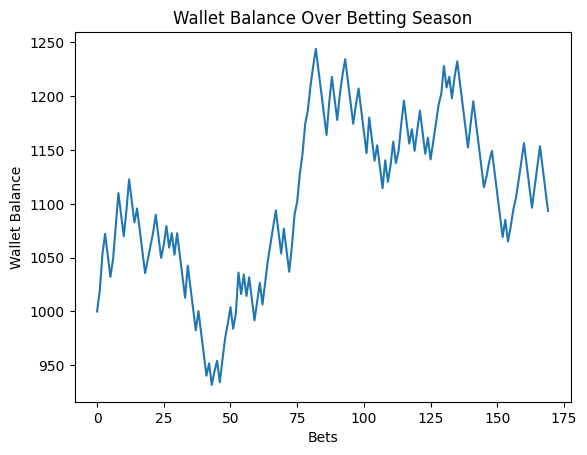

In [ ]:

subset_df = merged_player_dataframe[(merged_player_dataframe['Date'] >= date1) & (merged_player_dataframe['Date'] <= date2)]
player_list = subset_df['lineup'].to_frame()

results, bets, skipped = predict_game_outcome(player_list, train_player_data, model, augment=False, scaler=10, base_bet=20)

final_bets = generate_bets(results, bets, subset_df, skipped)

print('Number of games: ', len(subset_df))
print('Predictions: ', results)
print('Bets: ', bets)

wallet_balance, wallet_balance_history = simulate_betting_season(final_bets, merged_dataframes)
print(wallet_balance)
print(wallet_balance_history)
plt.plot(wallet_balance_history)
plt.title('Wallet Balance Over Betting Season')
plt.xlabel('Bets')
plt.ylabel('Wallet Balance')
plt.show()

In [ ]:
len(merged_dataframes)

967

In [ ]:
print(final_bets)

[(20, 'PHI', 20210401), (20, 'DET', 20210401), (20, 'HOU', 20210401), (20, 'MIN', 20210401), (20, 'BOS', 20210402), (20, 'PHI', 20210403), (20, 'DET', 20210403), (20, 'BAL', 20210403), (20, 'OAK', 20210403), (20, 'MIL', 20210403), (20, 'PHI', 20210404), (20, 'BAL', 20210404), (20, 'MIL', 20210404), (20, 'TEX', 20210405), (20, 'WAS', 20210406), (20, 'MIN', 20210406), (20, 'TOR', 20210406), (20, 'WAS', 20210407), (20, 'ATL', 20210407), (20, 'ATL', 20210407), (20, 'ATL', 20210407), (20, 'COL', 20210407), (20, 'TOR', 20210407), (20, 'BAL', 20210408), (20, 'HOU', 20210408), (20, 'ATL', 20210409), (20, 'HOU', 20210409), (20, 'ATL', 20210410), (20, 'BAL', 20210410), (20, 'ARI', 20210411), (20, 'ATL', 20210411), (20, 'BAL', 20210411), (20, 'DET', 20210411), (20, 'MIA', 20210412), (20, 'ARI', 20210412), (20, 'ATL', 20210413), (20, 'MIN', 20210413), (20, 'OAK', 20210413), (20, 'ATL', 20210414), (20, 'MIN', 20210414), (20, 'MIN', 20210414), (20, 'ATL', 20210415), (20, 'WAS', 20210415), (20, 'MIN'

In [ ]:
# len(final_bets)
len(train_player_data)

3741

# Misc

In [ ]:
missing_players = check_missing_players(player_list, train_player_data)
print('Missing players:', missing_players)
len(missing_players)

Missing players: ['l', 'i', 'n', 'e', 'u', 'p']


6

In [ ]:
print(skipped)
# for index in skipped:missing_players_per_game = []


[4, 12, 14, 16, 17, 20, 21, 24, 30, 32, 34, 37, 38, 41, 42, 43, 44, 50, 52, 56, 57, 58, 59, 60, 63, 65, 67, 71, 72, 73, 74, 75, 79, 80, 81, 87, 91, 92, 94, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 118, 119, 120, 122, 123, 124, 126, 132, 133, 135, 136, 139, 140, 143, 147, 150, 155, 156, 160, 161, 163, 166, 173, 176, 178, 181, 182, 187, 188, 193, 194, 195, 197, 202, 203, 205, 206, 211, 213, 216, 217, 221, 224, 226, 227, 228, 229, 231, 234, 235, 236, 238, 240, 241, 242, 243, 244, 245, 248, 252, 253, 257, 260, 261, 265, 267, 268, 270, 274, 275, 279, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 294, 295, 297, 298, 299, 300, 301, 307, 309, 311, 312, 313, 314, 315, 316, 319, 320, 321, 322, 323, 325, 326, 327, 332, 334, 335, 340, 343, 344, 345, 346, 348, 349, 352, 358, 360, 362, 364, 367, 368, 371, 372, 373, 374, 375, 376, 379, 380, 381, 383, 384, 385, 386, 388, 389, 390, 391, 393, 394, 395, 396, 397, 398, 399, 400, 402, 403, 404, 405, 407, 410, 411, 414, 416, 417,

In [ ]:
len(pd.DataFrame(train_player_data.keys()))
len(player_list)

967

In [ ]:
# extra_players_per_game = []
# for game in player_list_df.iloc[:, 0]:
#     # Flatten the list of players for the current game
#     game_players_flat = [player for sublist in game for player in sublist]
#     # Convert the list into a set to remove duplicates
#     game_player_set = set(game_players_flat)
#     extra_players = train_player_set - game_player_set
#     extra_players_per_game.append(extra_players)

# print(extra_players_per_game)

In [ ]:
def check_missing_players_per_game(player_list, player_data):
    missing_players_per_game = []
    for game in player_list:
        missing_players = []
        for team in game:
            for player in team:
                if player.lower() not in player_data:
                    missing_players.append(player)
        missing_players_per_game.append(missing_players)
    return missing_players_per_game

missing_players_per_game = check_missing_players_per_game(player_list['lineup'], train_player_data) #Check if there are any wrong player names between the two datasets
# missing_players_per_game = check_missing_players_per_game(player_list['lineup'], train_player_data) #Check if there are any players  
for i, missing_players in enumerate(missing_players_per_game):
    print(f'Missing players for game {i+1}:', missing_players)

Missing players for game 1: []
Missing players for game 2: []
Missing players for game 3: []
Missing players for game 4: []
Missing players for game 5: ["Ka'ai Tom"]
Missing players for game 6: []
Missing players for game 7: []
Missing players for game 8: []
Missing players for game 9: []
Missing players for game 10: []
Missing players for game 11: []
Missing players for game 12: []
Missing players for game 13: ['Akil Baddoo']
Missing players for game 14: []
Missing players for game 15: ['Chas McCormick', "Ka'ai Tom"]
Missing players for game 16: []
Missing players for game 17: ['Jonathan India']
Missing players for game 18: ['Akil Baddoo']
Missing players for game 19: []
Missing players for game 20: []
Missing players for game 21: ['Jonathan India']
Missing players for game 22: ['Geraldo Perdomo']
Missing players for game 23: []
Missing players for game 24: []
Missing players for game 25: ['Jonathan India']
Missing players for game 26: []
Missing players for game 27: []
Missing player

In [ ]:
def remove_empty_and_duplicate_games(missing_players_per_game):
    filtered_games = []
    for game in missing_players_per_game:
        if game and game not in filtered_games:
            filtered_games.append(game)
    return filtered_games

filtered_games = remove_empty_and_duplicate_games(missing_players_per_game)
for i, missing_players in enumerate(filtered_games):
    print(f'Missing players for game {i+1}:', missing_players)



Missing players for game 1: ["Ka'ai Tom"]
Missing players for game 2: ['Akil Baddoo']
Missing players for game 3: ['Chas McCormick', "Ka'ai Tom"]
Missing players for game 4: ['Jonathan India']
Missing players for game 5: ['Geraldo Perdomo']
Missing players for game 6: ['Taylor Trammell']
Missing players for game 7: ['Alex Kirilloff']
Missing players for game 8: ['Akil Baddoo', 'Ronnie Dawson']
Missing players for game 9: ['Taylor Trammell', 'Ryan McKenna']
Missing players for game 10: ['Alex De Goti', 'Chas McCormick', 'Taylor Trammell']
Missing players for game 11: ['Josh Palacios']
Missing players for game 12: ['Ryan McKenna']
Missing players for game 13: ['Chas McCormick']
Missing players for game 14: ['Zack Short']
Missing players for game 15: ['Rodolfo Castro', 'Akil Baddoo']
Missing players for game 16: ['Nick Maton']
Missing players for game 17: ['Taylor Trammell', 'Chas McCormick']
Missing players for game 18: ['Kohei Arihara']
Missing players for game 19: ['Paul Campbell', 'Pa

In [ ]:
# train_dataset = vector_dataset(X_train_resampled, y_train_resampled)
# instantiate the random undersampler
#rus = RandomUnderSampler(random_state=42)

# instantiate SMOTE
#smote = SMOTE(random_state=42)

# resample X_train and y_train using undersampling
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# resample X_train and y_train using SMOTE
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print the new class distribution after undersampling
#print('Resampled dataset shape after undersampling %s' % len(X_train_resampled))

# print the new class distribution after SMOTE
#print('Resampled dataset shape after SMOTE %s' % len(X_train_smote))